Downloaded from the Single Cell Portal: https://singlecell.broadinstitute.org/single_cell/study/SCP1064/multi-modal-pooled-perturb-cite-seq-screens-in-patient-models-define-novel-mechanisms-of-cancer-immune-evasion

In [1]:
# %load block0_load.py
author_year = 'Frangieh_2021'
is_counts = False
var_genes = None
doi = '10.1038/s41588-021-00779-1'

import numpy as np
import pandas as pd
import scanpy as sc
sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

# verify
assert(doi in pd.read_csv('../personal.csv').DOI.values)

adata = sc.read(f'{author_year}_raw.h5ad')
adata

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-02-08 23:14:15.755003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 23:14:15.755029: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


AnnData object with n_obs × n_vars = 218331 × 23712
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [2]:
# %load block1_init.py
# metalabels
adata.uns['preprocessing_nb_link'] = f'https://nbviewer.org/github/theislab/sc-pert/blob/main/datasets/{author_year}_curation.ipynb'
adata.uns['doi'] = doi
display(adata.obs.describe(include='all').T.head(20))

# use gene symbols as gene names
if var_genes:
    adata.var[var_genes] = adata.var[var_genes].astype(str)
    adata.var = adata.var.reset_index().set_index(var_genes)
    print(adata.var_names)

# filtering and processing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)
adata.var_names_make_unique()

if is_counts:
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

count unique                   top    freq
library_preparation_protocol  218331      1  10X 3' v3 sequencing  218331
condition                     218331      3                  IFNγ   87590
MOI                           218331     20                     1  126966
sgRNA                         126966    818              IFNGR2_2     358
UMI_count                     218331  33077                7977.0      33

Add additional labels, normalize and add plotting variables.

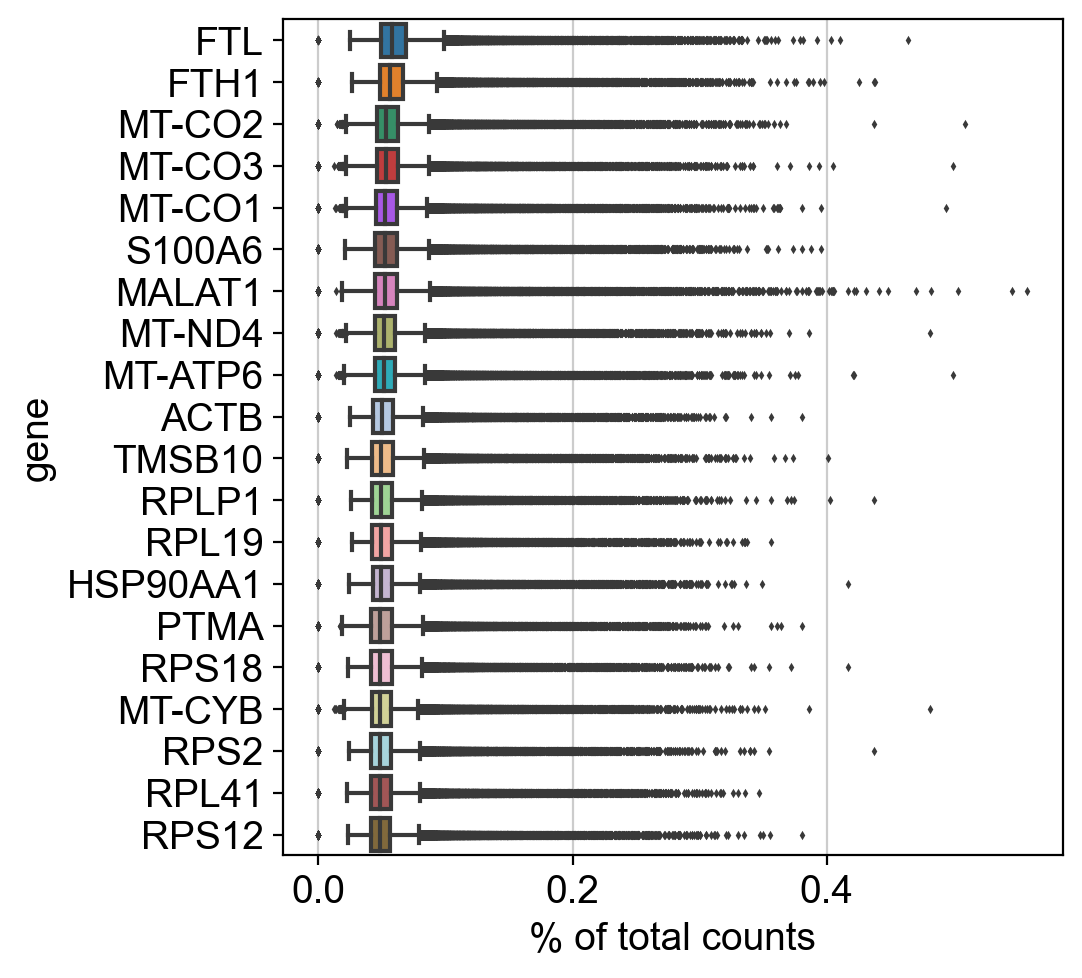

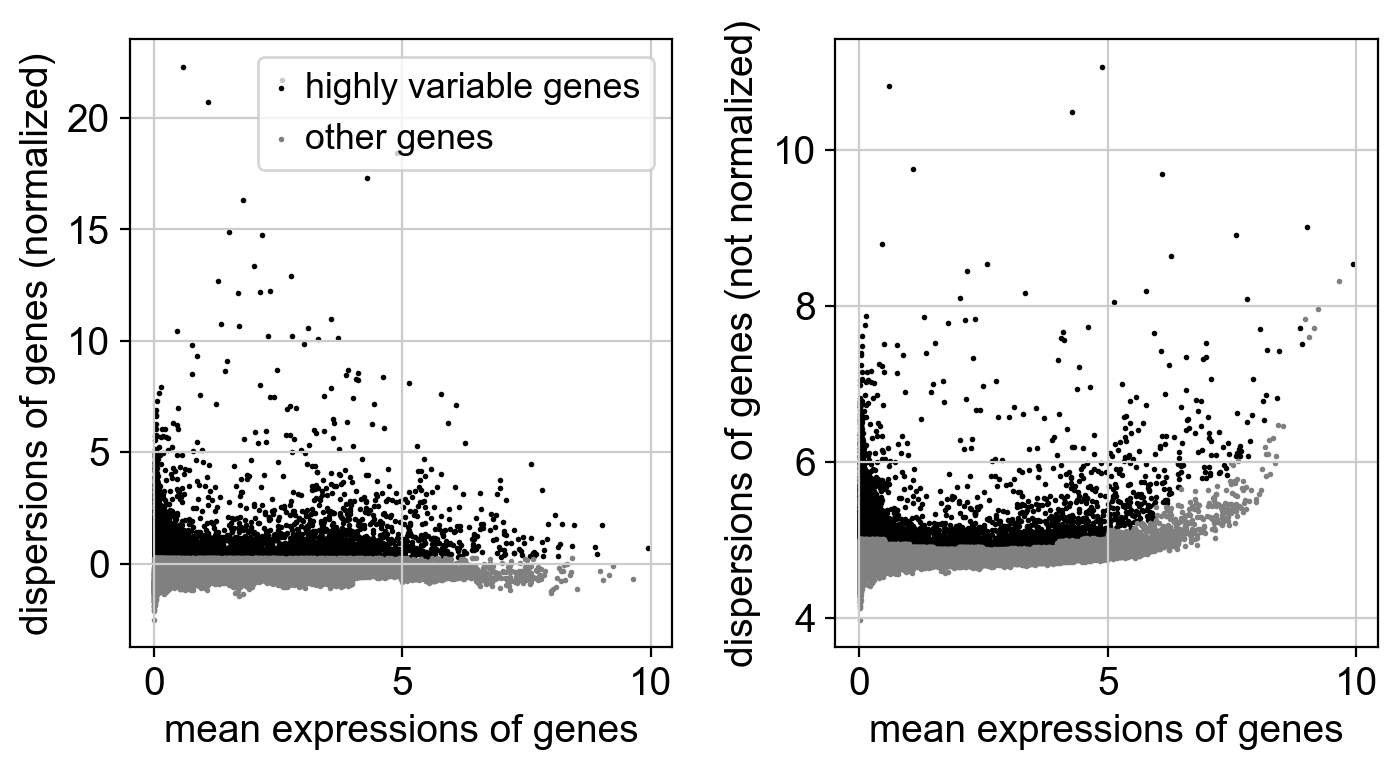

In [3]:
# %load block2_process.py
if is_counts:
    adata.layers['counts'] = adata.X
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=False)
sc.pl.highly_variable_genes(adata)

# pre-compute plots
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

Save.

In [4]:
sc.write(f'{author_year}.h5ad', adata, compression='gzip')
adata

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'MOI' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'UMI_count' as categorical


AnnData object with n_obs × n_vars = 218331 × 22097
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'preprocessing_nb_link', 'doi', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'protein_expression', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Standardized perturbation labels and save again.

In [ ]:
# adata = sc.read(f'{author_year}.h5ad')

In [5]:
# %load block3_standardize.py
# the following fields are meant to serve as a template
adata.obs['perturbation_name'] = adata.obs['sgRNA']
adata.obs['perturbation_type'] = 'genetic'
adata.obs['perturbation_value'] = adata.obs['MOI'].astype('int')
adata.obs['perturbation_unit'] = 'million virons'

In [10]:
sc.write(f'{author_year}.h5ad', adata, compression='gzip')
adata

AnnData object with n_obs × n_vars = 218331 × 22097
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'preprocessing_nb_link', 'doi', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'library_preparation_protocol_colors', 'condition_colors', 'MOI_colors', 'leiden_colors', 'perturbation_type_colors', 'perturbation_value_colors', 'perturbation_unit_colors'
    obsm: 'protein_expression', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

View.

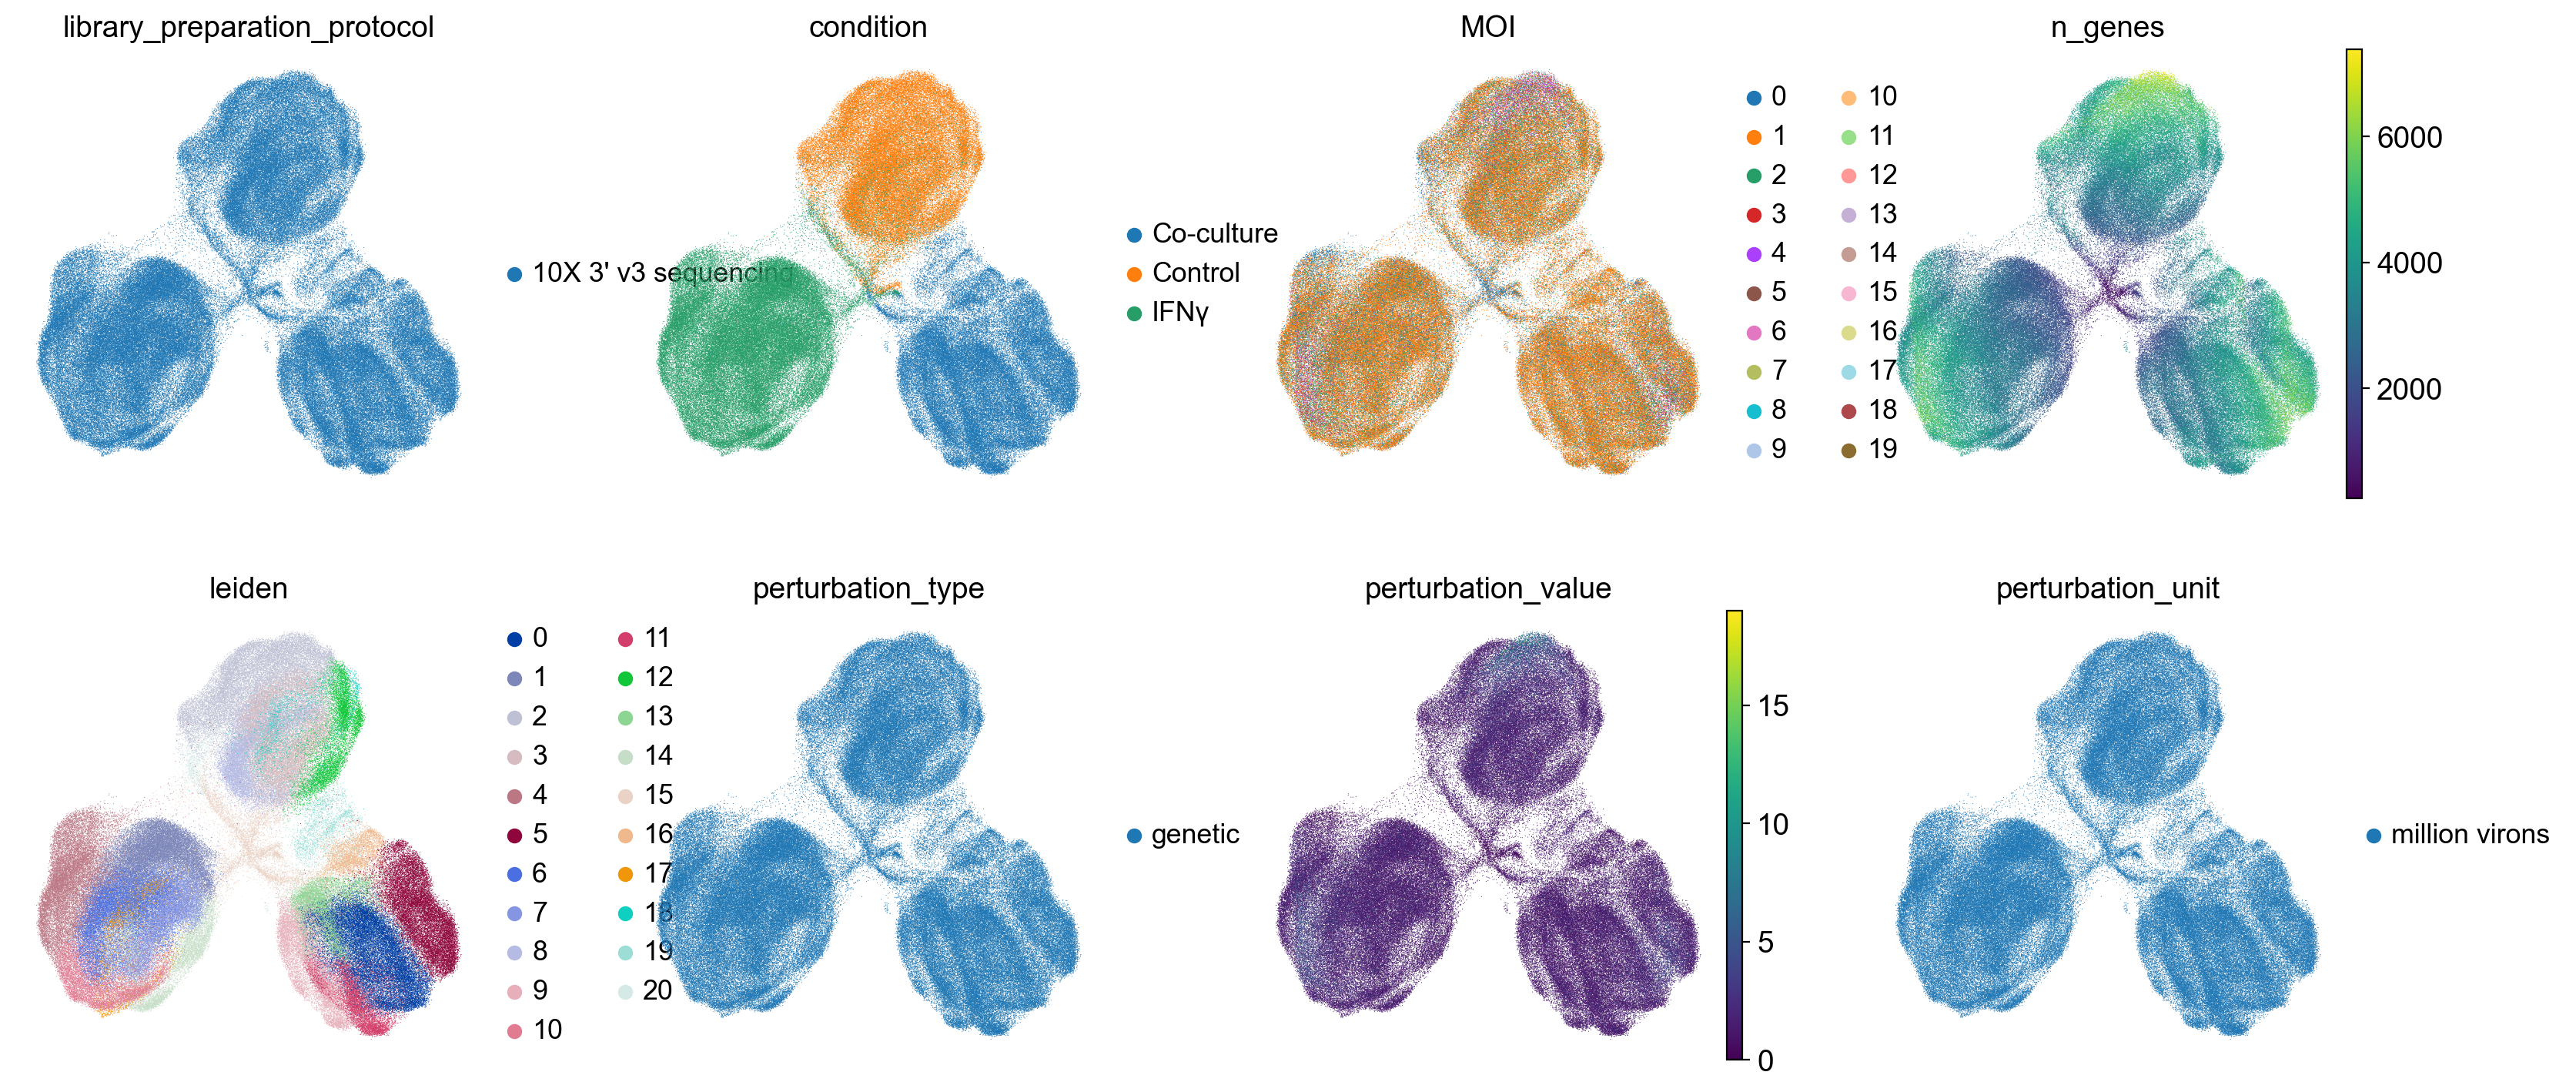

In [9]:
plot_cols = [c for c in adata.obs.columns if len(adata.obs[c].unique()) < 30 or not hasattr(adata.obs[c], 'cat')]
for c in plot_cols:
    if adata.obs[c].dtype == 'bool':
        adata.obs[c] = adata.obs[c].astype('category')
sc.pl.umap(adata, color=plot_cols)